In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import datasets

from model import Generator, Discriminator
from train import train_DCGAN

device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

### Code for loading the numpy array of different datasets, two numpy arrays can be created separately for Jazz and classical and they can be concatenated

In [2]:
import numpy as np
import matplotlib.pyplot as plt
with open("numpy_data.npy","rb") as f:
    pixels = np.load(f)


In [4]:
pixels = np.resize(pixels,(1201,1,128 ,128))

In [5]:
pixels.shape

(1201, 1, 128, 128)

### create separate labels for classical dataset namely label = 2 and then concatnate both the labels. 

In [13]:
labels = np.array([1]*len(pixels))

### Create train data for both the datsets. 

In [15]:
train_data = []
for i in range(len(pixels)):
   train_data.append([pixels[i], labels[i]])

In [8]:
g_lr = 0.02
d_lr = 0.00002
batch_size = 128
num_epochs = 170
n_class = 1

In [18]:

#train_set = MNIST(root='.', train=True, transform=trans, download=True)
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [21]:
def label2onehot(labels):
    uni_labels = labels.unique(sorted=True)
    k = 0
    dic = {}
    for l in uni_labels:
        dic[str(l.item())] = k
        k += 1
    for (i, l) in enumerate(labels):
        labels[i] = dic[str(l.item())]
    return labels


def CrossEntropy_uniform(pred,batch_size,n_class):
    logsoftmax = nn.LogSoftmax(dim=1)
    unif = torch.full((batch_size, n_class), 1/n_class)
    return torch.mean(-torch.sum(unif * logsoftmax(pred), 1))

In [ ]:

n_class = 1
G = Generator().to(device)
D = Discriminator().to(device)

optim_G = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.05, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.05, 0.999))

loss_f1 = nn.BCELoss()
loss_f2 = nn.CrossEntropyLoss()


train_DCGAN(G, D, optim_G, optim_D, loss_f1, loss_f2, train_loader, num_epochs, label2onehot, 
            CrossEntropy_uniform, n_class,
            device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


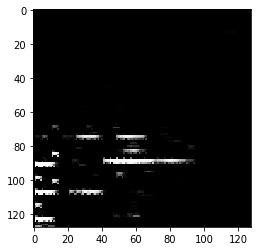

In [16]:
from torchvision.utils import make_grid
noise = torch.randn(1, 100, device=device)
img_fake = G(noise)
grid = make_grid(img_fake)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

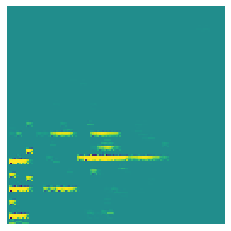

In [18]:
plt.axis('off')
plt.imshow(img_fake[0][0].detach().cpu().numpy())
plt.savefig('GeneratedJazz1.png', bbox_inches=0, pad_inches=0, transparent=False)

In [ ]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((384, 432,3))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))

import sys
image_path = './GeneratedJazz0.png'
image2midi(image_path)

In [ ]:
377110/(288*432)

In [ ]:
497664/432/384

In [ ]:
128*3